In [2]:
import pandas as pd
from pyeutl.orm import Transaction,DataAccessLayer,Installation,Account,AccountHolder,AccountType
from sqlalchemy import select,func

connectionSettings = dict(
    user="postgres", 
    host="localhost", 
    db="eutl2024", 
    passw="password",
    port=5432
)

dal = DataAccessLayer(**connectionSettings)
session = dal.session
session.rollback()  



Extraire les transactions de chaque compte

In [3]:
from pyeutl.orm import AccountType
from sqlalchemy.orm import Session, joinedload

#Etape 1: Je récupère les comptes et le type des comptes:

accounts = []
#en utilisant les tables Account et AccountType
stmt = select(
Account.id.label('account_id') ,
Account.accountHolder_id,
AccountType.description.label('account_type')).join(
    AccountType, Account.accountType_id == AccountType.id
)

account_info = session.execute(stmt).fetchall()

accounts_df = pd.DataFrame(account_info)
 #je regarde si il y a des NA
print(accounts_df.isna().sum()/len(accounts_df))

account_id          0.000000
accountHolder_id    0.000092
account_type        0.000000
dtype: float64


In [4]:

#Etape 2: Je récupère les transactions
final_df = pd.DataFrame()
#les transactions acquired
stmt_acquired = select(
    Transaction.acquiringAccount_id.label('account_id'),
    func.to_char(Transaction.date, 'MM-YYYY').label('month'),
    func.sum(Transaction.amount).label('acquired_amount')
).group_by(
    Transaction.acquiringAccount_id,
    func.to_char(Transaction.date, 'MM-YYYY')
)
df_acquired = pd.read_sql(stmt_acquired, session.bind)

#je regarde si il y a des NA
print(df_acquired.isna().sum()/len(df_acquired))

account_id         0.000159
month              0.000000
acquired_amount    0.000000
dtype: float64


In [5]:
#les transactions transferred
stmt_transferred = select(
    Transaction.transferringAccount_id.label('account_id'),
    func.to_char(Transaction.date, 'MM-YYYY').label('month'),
    func.sum(Transaction.amount).label('transferred_amount')
).group_by(
    Transaction.transferringAccount_id,
    func.to_char(Transaction.date, 'MM-YYYY')
)
df_transferred = pd.read_sql(stmt_transferred, session.bind)
print(df_transferred.isna().sum()/len(df_transferred))

account_id            0.000216
month                 0.000000
transferred_amount    0.000000
dtype: float64


In [6]:
#Merger les bases
df = pd.merge(df_transferred,df_acquired,on=['account_id', 'month'],how='outer' )
df.sort_values(by=['account_id', 'month'], inplace=True)
df.reset_index(drop=True, inplace=True)
df = pd.merge(df,accounts_df, on='account_id', how='outer')

Ajouter le nace code 

In [7]:
df['month'] = pd.to_datetime(df['month'], format='%m-%Y')

# Filtrer les données pour inclure uniquement les entrées à partir de janvier 2008
df = df[df['month'] < '2021-01-01']

In [8]:
stmt =select(
    Account.id.label('account_id'),
    Installation.nace_id
).join(Installation, Account.installation_id == Installation.id)
nace_code  = session.execute(stmt).fetchall()
df_nace  = pd.DataFrame(nace_code)
df_nace.isna().sum()/len(df_nace)

account_id    0.00000
nace_id       0.05788
dtype: float64

In [9]:
dnace_subset = df_nace.drop_duplicates()
df = pd.merge(df,dnace_subset, on='account_id',how='left')

In [10]:
df.isna().sum()/len(df)

account_id            0.000143
month                 0.000000
transferred_amount    0.389193
acquired_amount       0.338270
accountHolder_id      0.016536
account_type          0.015993
nace_id               0.188504
dtype: float64

In [11]:
#avant suppression NA
len(df)

504600

Supprimer les NA des accountHolder_id, account_type et account_id

In [12]:
df_cleaned = df.dropna(subset=['account_id', 'account_type', 'accountHolder_id'])
len(df_cleaned)

496256

Définir les types de comptes financiers et régularisés comme dans l'article

In [13]:
len(df_cleaned[df_cleaned['Type']=='other'])/len(df_cleaned)

KeyError: 'Type'

In [ ]:
df_cleaned['account_type'].unique()

array(['Voluntary Cancellation Account (Type 3)', 'Party Holding Account',
       'Retirement Account', 'Former Operator Holding Account',
       'Person Account in National Registry', 'AAU Deposit Account',
       'Net Source Cancellation Account (Type 1)',
       'Mandatory (Cancellation Account (Type 5)',
       'Person Holding Account', 'Trading Account',
       'National Allowance Holding Account', 'Gateway Deposit Account',
       'Aircraft Operator Account', 'Operator Holding Account',
       'Central Clearing Account', 'Union Allowance Deletion Account',
       'Auction Delivery Account', 'Auction Account',
       'Aviation Auction Account', 'Aviation Surrender Set-Aside Account',
       'Allocation Account', 'Aviation Allocation Account',
       'tCER Replacement Account for Expiry (Type 1)',
       'EU Effort Sharing Account'], dtype=object)

In [ ]:
regulate_ids = df_cleaned[df_cleaned['account_type'].isin(['Operator Holding Account', 'Aircraft Operator Account'])]['accountHolder_id'].unique().tolist()
df_cleaned['Type']='other'
df_cleaned.loc[df_cleaned['accountHolder_id'].isin(regulate_ids),'Type'] = 'regulating'

C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\433450459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Type']='other'


In [ ]:
government_ids = df_cleaned[
    (df_cleaned["account_type"].isin([
        'Person Account in National Registry', 
        'Verifier Account',
        'Party Holding Account',
        'ESD Compliance Account',
        'National Allowance Holding Account',
        'Voluntary Cancellation Account (Type 3)',
        'Voluntary Cancellation Account',
        'Retirement Account'
    ])) & (df_cleaned['Type'] == 'other')
]['accountHolder_id'].unique().tolist()

df_cleaned.loc[df_cleaned['accountHolder_id'].isin(government_ids),'Type'] = 'governmental'


In [ ]:
financial_ids = df_cleaned[
    (df_cleaned["account_type"].isin([
        'Trading Account',
 'Person Holding Account' 
    ])) & (df_cleaned['Type'] == 'other')
]['accountHolder_id'].unique().tolist()

df_cleaned.loc[df_cleaned['accountHolder_id'].isin(financial_ids),'Type'] = 'financial'

In [ ]:
for account in accounts:
    print(account,':',len(df_cleaned[df_cleaned['account_type']==account]["account_id"].unique()))

other : 0
regulating : 0
governmental : 0
financial : 0


Il reste 4% de comptes non classifiés que nous décidons pour le moment de laisser de côté

In [ ]:
session.rollback()

former_account_ids = df_cleaned[df_cleaned['account_type']=='Former Operator Holding Account']["account_id"].unique().tolist()

stmt = select(Account.isOpen).where(Account.id.in_((former_account_ids)))
isopen = pd.DataFrame(session.execute(stmt).fetchall())


In [ ]:
sum(isopen['isOpen'])/len(isopen)

0.12501955875449852

In [ ]:
print(df_cleaned.isnull().sum()/len(df_cleaned))

account_id            0.000000
month                 0.000000
transferred_amount    0.388453
acquired_amount       0.335331
accountHolder_id      0.000000
account_type          0.000000
nace_id               0.174859
Type                  0.000000
dtype: float64


In [ ]:
df_cleaned['transferred_amount'].fillna(0, inplace=True)
df_cleaned['acquired_amount'].fillna(0, inplace=True)

C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\2945322722.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['transferred_amount'].fillna(0, inplace=True)
C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\2945322722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['transferred_amount'].fillna(0, inplace=True)
C:\Us

In [ ]:
len(df_cleaned[df_cleaned['Type']=='other'])/len(df_cleaned)

0.05938110683562665

In [ ]:
import pandas as pd


regulating_df = df_cleaned[df_cleaned['Type'] == 'regulating']
financial_df = df_cleaned[df_cleaned['Type'] == 'financial']


df2 = pd.DataFrame(df_cleaned['month'].unique(), columns=['month'])

# Setting 'month' as the index for easy merging
df2.set_index('month', inplace=True)

# Grouping and summing 'acquired_amount' and 'transferred_amount' by 'month' for both types

invol_reg = regulating_df.groupby('month')['acquired_amount'].sum()
outvol_reg = regulating_df.groupby('month')['transferred_amount'].sum()
invol_fin = financial_df.groupby('month')['acquired_amount'].sum()
outvol_fin = financial_df.groupby('month')['transferred_amount'].sum()

# Merging these sums into df2
df2['InVolReg'] = invol_reg
df2['OutVolReg'] = outvol_reg
df2['InVolFin'] = invol_fin
df2['OutVolFin'] = outvol_fin
df2['InVolReg'].fillna(0, inplace=True)
df2['OutVolReg'].fillna(0, inplace=True)
df2['InVolFin'].fillna(0, inplace=True)
df2['OutVolFin'].fillna(0, inplace=True)

# # Calculating total volumes
df2['TVolFin'] = df2['InVolFin'] + df2['OutVolFin']
df2['TVolReg'] = df2['InVolReg'] + df2['OutVolReg']

# Resetting index if necessary
df2.reset_index(inplace=True)


C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\3942686549.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regulating_df['total_acquired'] = regulating_df['acquired_amount'] + regulating_df['allocatedTotal']
C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\3942686549.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the opera

In [ ]:
print(df2.isna().sum())

month        0
InVolReg     0
OutVolReg    0
InVolFin     0
OutVolFin    0
TVolFin      0
TVolReg      0
dtype: int64


In [ ]:
df2.sort_values(by=['month'], inplace=True)
df2.head()

,month,InVolReg,OutVolReg,InVolFin,OutVolFin,TVolFin,TVolReg
5,2005-01-01,0.0,0.0,0.0,0.0,0.0,0.0
11,2005-02-01,119152454.0,552263.0,40471.0,0.0,40471.0,119704717.0
74,2005-03-01,17104027.0,12048109.0,5537.0,0.0,5537.0,29152136.0
23,2005-04-01,259944621.0,952292.0,107522.0,0.0,107522.0,260896913.0
29,2005-05-01,335131242.0,5441993.0,2452864.0,0.0,2452864.0,340573235.0


In [ ]:
regulating_df['NetAmountReg'] = regulating_df['acquired_amount'] - regulating_df['transferred_amount']

monthly_net = regulating_df.groupby('month')['NetAmountReg'].sum()

df2 = pd.merge(df2,monthly_net,how='left',on='month')
df2['NetAmountReg'].fillna(0,inplace=True)
df2['WalletReg'] = df2['NetAmountReg'].cumsum()


df2.head()

C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\1447758493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regulating_df['NetAmountReg'] = regulating_df['acquired_amount'] - regulating_df['transferred_amount']
C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\1447758493.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the opera

,month,InVolReg,OutVolReg,InVolFin,OutVolFin,TVolFin,TVolReg,NetAmountReg,WalletReg
0,2005-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2005-02-01,119152454.0,552263.0,40471.0,0.0,40471.0,119704717.0,118600191.0,118600191.0
2,2005-03-01,17104027.0,12048109.0,5537.0,0.0,5537.0,29152136.0,5055918.0,123656109.0
3,2005-04-01,259944621.0,952292.0,107522.0,0.0,107522.0,260896913.0,258992329.0,382648438.0
4,2005-05-01,335131242.0,5441993.0,2452864.0,0.0,2452864.0,340573235.0,329689249.0,712337687.0


In [ ]:
financial_df['NetAmountFin'] = financial_df['acquired_amount'] - financial_df['transferred_amount']

monthly_net = financial_df.groupby('month')['NetAmountFin'].sum()

df2 = pd.merge(df2,monthly_net,how='left',on='month')
df2['NetAmountFin'].fillna(0,inplace=True)
df2['WalletFin'] = df2['NetAmountFin'].cumsum()

df2.head()

C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\2191015914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_df['NetAmountFin'] = financial_df['acquired_amount'] - financial_df['transferred_amount']
C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\2191015914.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operatio

,month,InVolReg,OutVolReg,InVolFin,OutVolFin,TVolFin,TVolReg,NetAmountReg,WalletReg,NetAmountFin,WalletFin
0,2005-01-01,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
1,2005-02-01,1.191525e+08,5.522630e+05,40471.0,0.0,40471.0,1.197047e+08,1.186002e+08,1.186002e+08,40471.0,40471.0
2,2005-03-01,1.710403e+07,1.204811e+07,5537.0,0.0,5537.0,2.915214e+07,5.055918e+06,1.236561e+08,5537.0,46008.0
3,2005-04-01,2.599446e+08,9.522920e+05,107522.0,0.0,107522.0,2.608969e+08,2.589923e+08,3.826484e+08,107522.0,153530.0
4,2005-05-01,3.351312e+08,5.441993e+06,2452864.0,0.0,2452864.0,3.405732e+08,3.296892e+08,7.123377e+08,2452864.0,2606394.0
5,2005-06-01,1.078357e+08,1.229222e+07,64069.0,0.0,64069.0,1.201279e+08,9.554351e+07,8.078812e+08,64069.0,2670463.0
6,2005-07-01,2.638106e+07,2.067926e+07,900.0,0.0,900.0,4.706031e+07,5.701798e+06,8.135830e+08,900.0,2671363.0
7,2005-08-01,1.963210e+07,3.152715e+06,10.0,10.0,20.0,2.278481e+07,1.647938e+07,8.300624e+08,0.0,2671363.0
8,2005-09-01,4.910146e+07,4.313983e+06,0.0,0.0,0.0,5.341544e+07,4.478748e+07,8.748499e+08,0.0,2671363.0
9,2005-10-01,1.030646e+08,1.206742e+07,20.0,0.0,20.0,1.151320e+08,9.099721e+07,9.658471e+08,20.0,2671383.0


In [ ]:
def reset_cumsum(series, reset_date):
    series['month'] = pd.to_datetime(series['month'], format='%Y-%m-%d')
    reset_date = pd.to_datetime(reset_date)
    
    # Cumulative sum with reset.
    cumsum = []
    current_sum = 0
    for index, row in series.iterrows():
        if row['month'] >= reset_date:
            current_sum = 0  # Reset the cumulative sum from this date forward.
        current_sum += row['NetAmountReg']
        cumsum.append(current_sum)
    return cumsum

# Apply the custom cumulative sum with a reset starting January 2012.
df2['WalletReg2'] = reset_cumsum(df2[['month', 'NetAmountReg']], '2012-01-01')

C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\1363284525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series['month'] = pd.to_datetime(series['month'], format='%Y-%m-%d')


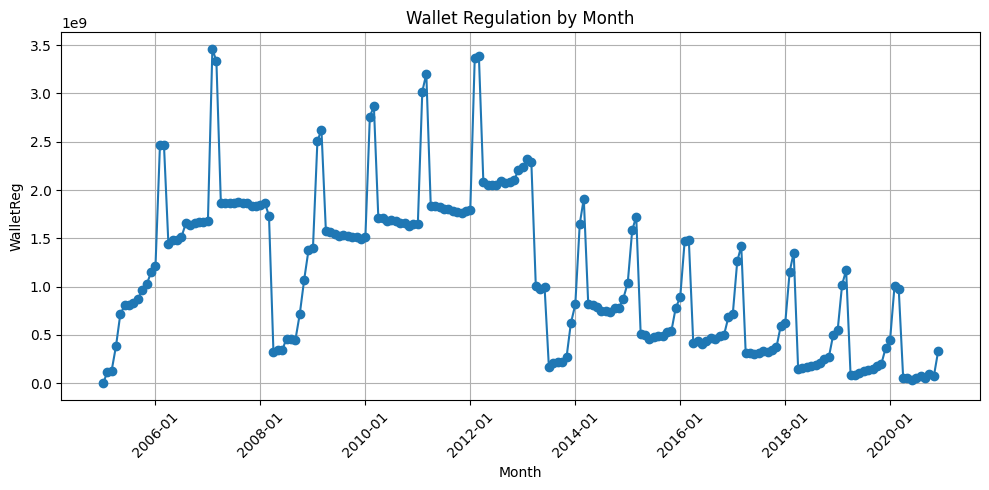

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Tracer la courbe
plt.figure(figsize=(10, 5))  # Définir la taille de la figure
plt.plot(df2['month'], df2['WalletReg'], marker='o', linestyle='-')  # Tracer la ligne avec des points

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# Ajouter des titres et des étiquettes
plt.title('Wallet of Regulated Entities')
plt.xlabel('Month')
plt.ylabel('Wallet')

plt.xticks(rotation=45)  # Rotation des étiquettes de mois pour une meilleure lisibilité

# Afficher le graphique
plt.grid(True)  # Ajouter une grille
plt.tight_layout()  # Ajuster automatiquement les paramètres de la subpot pour donner un padding qui rend tout visible
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Tracer la courbe
plt.figure(figsize=(10, 5))  # Définir la taille de la figure
plt.plot(df2['month'], df2['WalletFin'], marker='o', linestyle='-')  # Tracer la ligne avec des points

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# Ajouter des titres et des étiquettes
plt.title('Wallet of Financial Entities')
plt.xlabel('Month')
plt.ylabel('Wallet')

# Améliorer la mise en forme de l'axe des abscisses si nécessaire
plt.xticks(rotation=45)  # Rotation des étiquettes de mois pour une meilleure lisibilité

# Afficher le graphique
plt.grid(True)  # Ajouter une grille
plt.tight_layout()  # Ajuster automatiquement les paramètres de la subpot pour donner un padding qui rend tout visible
plt.show()


NameError: name 'df2' is not defined

<Figure size 1000x500 with 0 Axes>

Regrouper les nace code a l'aide de Cluster

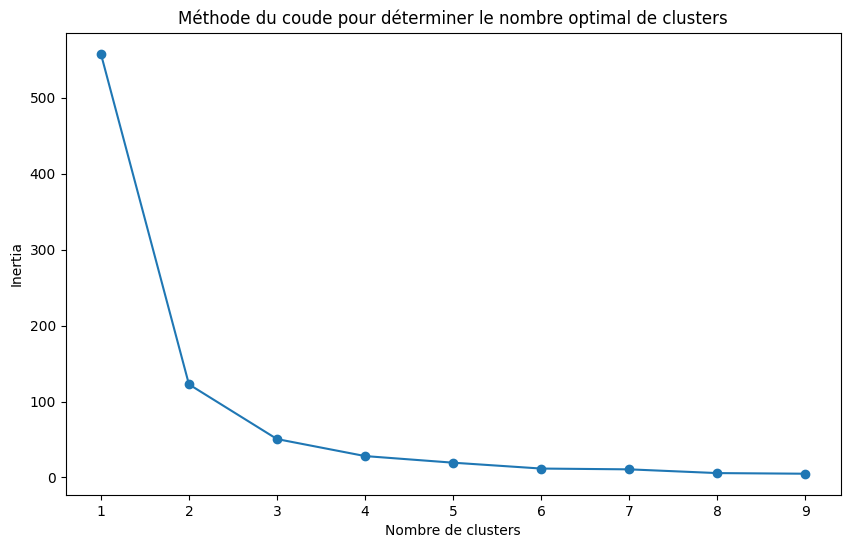

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


df_aggregated = df_cleaned.groupby('nace_id').agg({
    'transferred_amount': 'mean',  # ou 'mean' selon la pertinence pour l'analyse
    'acquired_amount': 'mean'      # idem
}).reset_index()

# Sélection des colonnes numériques pour le clustering
features = df_aggregated[['transferred_amount', 'acquired_amount']]

# Standardisation des données
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Choix du nombre de clusters avec la méthode du coude
inertia = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertia')
plt.show()


    nace_id  transferred_amount  acquired_amount  cluster
0     01.11         1527.800000      1721.457143        0
1     01.13         9277.779946      9001.462331        0
2     01.19         6364.784512      6117.373737        0
3     01.21         6227.271429      6636.064286        0
4     01.22         5894.775281      5893.797753        0
..      ...                 ...              ...      ...
274   85.41         8209.194030      8232.179104        0
275   85.42         4825.198507      4920.252239        0
276   86.10         5335.619327      5296.432909        0
277   86.21         1522.714286      1536.714286        0
278   86.90         3571.333333      3571.333333        0

[279 rows x 4 columns]


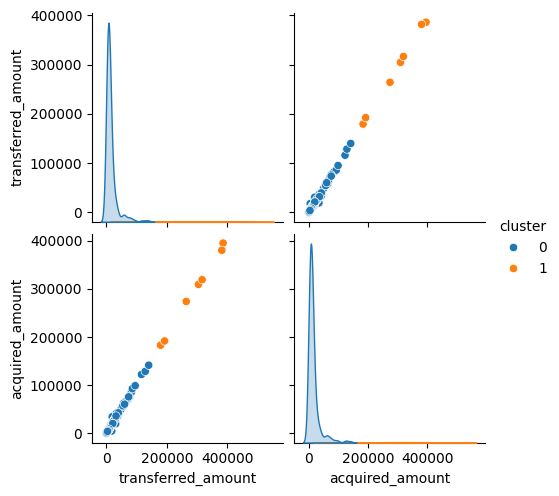

In [ ]:

kmeans = KMeans(n_clusters=2, random_state=42)
df_aggregated['cluster'] = kmeans.fit_predict(features_scaled)

# Affichage des résultats
print(df_aggregated)

# Analyse des clusters
import seaborn as sns
sns.pairplot(df_aggregated, hue='cluster', vars=['transferred_amount', 'acquired_amount'])
plt.show()

Cluster1 = l'industrie lourde, l'énergie et la production de matériaux

07.10 - Extraction de minerais de fer
19.10 - Cokéfaction
19.20 - Raffinage du pétrole
23.51 - Fabrication de ciment
24.10 - Sidérurgie
35.1 - Production, transport et distribution d'électricité
35.11 - Production d'électricité

In [ ]:
cluster1 = df_aggregated[df_aggregated['cluster']==1]['nace_id'].unique()
df_cluster1 = df_cleaned[df_cleaned['nace_id'].isin(cluster1)]
cluster0 = df_aggregated[df_aggregated['cluster']==0]['nace_id'].unique()
df_cluster0 = df_cleaned[df_cleaned['nace_id'].isin(cluster0)]


In [ ]:
cluster1

array(['07.10', '19.10', '19.20', '23.51', '24.10', '35.1', '35.11'],
      dtype=object)

In [ ]:
import pandas as pd


regulating_df1 = df_cluster1[df_cluster1['Type'] == 'regulating']
financial_df1 = df_cluster1[df_cluster1['Type'] == 'financial']


df2_cluster1 = pd.DataFrame(df_cluster1['month'].unique(), columns=['month'])

# Setting 'month' as the index for easy merging
df2_cluster1.set_index('month', inplace=True)

# Grouping and summing 'acquired_amount' and 'transferred_amount' by 'month' for both types
invol_reg = regulating_df1.groupby('month')['acquired_amount'].sum()
outvol_reg = regulating_df1.groupby('month')['transferred_amount'].sum()
invol_fin = financial_df1.groupby('month')['acquired_amount'].sum()
outvol_fin = financial_df1.groupby('month')['transferred_amount'].sum()

# Merging these sums into df2
df2_cluster1['InVolReg'] = invol_reg
df2_cluster1['OutVolReg'] = outvol_reg
df2_cluster1['InVolFin'] = invol_fin
df2_cluster1['OutVolFin'] = outvol_fin
df2_cluster1['InVolReg'].fillna(0, inplace=True)
df2_cluster1['OutVolReg'].fillna(0, inplace=True)
df2_cluster1['InVolFin'].fillna(0, inplace=True)
df2_cluster1['OutVolFin'].fillna(0, inplace=True)

# # Calculating total volumes
df2_cluster1['TVolFin'] = df2_cluster1['InVolFin'] + df2_cluster1['OutVolFin']
df2_cluster1['TVolReg'] = df2_cluster1['InVolReg'] + df2_cluster1['OutVolReg']

# Resetting index if necessary
df2_cluster1.reset_index(inplace=True)


C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\2237196104.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2_cluster1['InVolReg'].fillna(0, inplace=True)
C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\2237196104.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [ ]:
print(df2_cluster1.isna().sum())

month        0
InVolReg     0
OutVolReg    0
InVolFin     0
OutVolFin    0
TVolFin      0
TVolReg      0
dtype: int64


In [ ]:
df2_cluster1.sort_values(by=['month'], inplace=True)
df2_cluster1.head()

,month,InVolReg,OutVolReg,InVolFin,OutVolFin,TVolFin,TVolReg
0,2005-02-01,67448612.0,546263.0,0.0,0.0,0.0,67994875.0
34,2005-03-01,10450883.0,5296649.0,0.0,0.0,0.0,15747532.0
37,2005-04-01,236029815.0,734801.0,0.0,0.0,0.0,236764616.0
38,2005-05-01,259778381.0,3620525.0,2400501.0,0.0,2400501.0,263398906.0
58,2005-06-01,76699308.0,8074718.0,0.0,0.0,0.0,84774026.0


In [ ]:
regulating_df1['NetAmountReg'] = regulating_df1['acquired_amount'] - regulating_df1['transferred_amount']

monthly_net1 = regulating_df1.groupby('month')['NetAmountReg'].sum()

df2_cluster1 = pd.merge(df2_cluster1,monthly_net1,how='left',on='month')
df2_cluster1['NetAmountReg'].fillna(0,inplace=True)
df2_cluster1['WalletReg'] = df2_cluster1['NetAmountReg'].cumsum()


df2_cluster1.head()

C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\3629092739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regulating_df1['NetAmountReg'] = regulating_df1['acquired_amount'] - regulating_df1['transferred_amount']
C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\3629092739.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the op

,month,InVolReg,OutVolReg,InVolFin,OutVolFin,TVolFin,TVolReg,NetAmountReg,WalletReg
0,2005-02-01,67448612.0,546263.0,0.0,0.0,0.0,67994875.0,66902349.0,66902349.0
1,2005-03-01,10450883.0,5296649.0,0.0,0.0,0.0,15747532.0,5154234.0,72056583.0
2,2005-04-01,236029815.0,734801.0,0.0,0.0,0.0,236764616.0,235295014.0,307351597.0
3,2005-05-01,259778381.0,3620525.0,2400501.0,0.0,2400501.0,263398906.0,256157856.0,563509453.0
4,2005-06-01,76699308.0,8074718.0,0.0,0.0,0.0,84774026.0,68624590.0,632134043.0


In [ ]:
financial_df1['NetAmountFin'] = financial_df1['acquired_amount'] - financial_df1['transferred_amount']

monthly_net1 = financial_df1.groupby('month')['NetAmountFin'].sum()

df2_cluster1 = pd.merge(df2_cluster1,monthly_net1,how='left',on='month')
df2_cluster1['NetAmountFin'].fillna(0,inplace=True)
df2_cluster1['WalletFin'] = df2_cluster1['NetAmountFin'].cumsum()


C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\3667385454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_df1['NetAmountFin'] = financial_df1['acquired_amount'] - financial_df1['transferred_amount']
C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\3667385454.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the opera

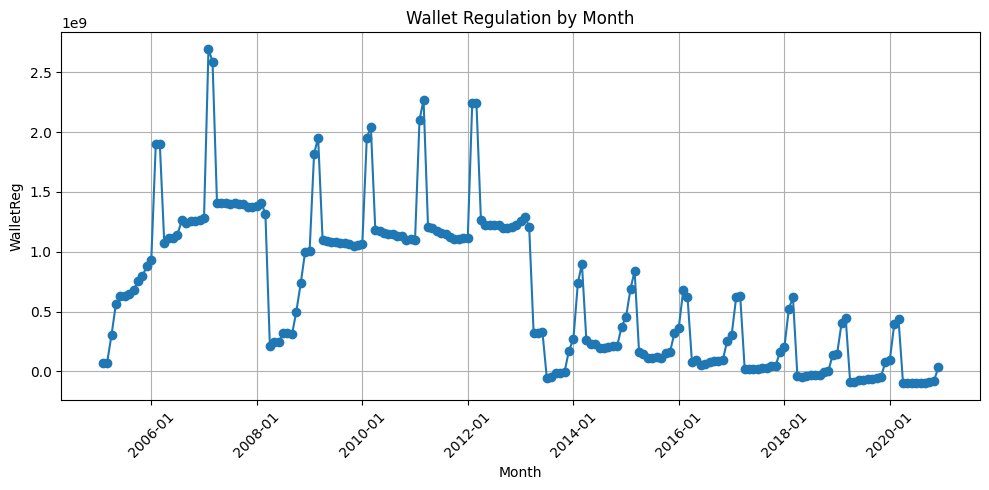

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Tracer la courbe
plt.figure(figsize=(10, 5))  # Définir la taille de la figure
plt.plot(df2_cluster1['month'], df2_cluster1['WalletReg'], marker='o', linestyle='-')  # Tracer la ligne avec des points

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# Ajouter des titres et des étiquettes
plt.title('Wallet of Regulated Entities of Cluster 1')
plt.xlabel('Month')
plt.ylabel('Wallet')

# Améliorer la mise en forme de l'axe des abscisses si nécessaire
plt.xticks(rotation=45)  # Rotation des étiquettes de mois pour une meilleure lisibilité

# Afficher le graphique
plt.grid(True)  # Ajouter une grille
plt.tight_layout()  # Ajuster automatiquement les paramètres de la subpot pour donner un padding qui rend tout visible
plt.show()


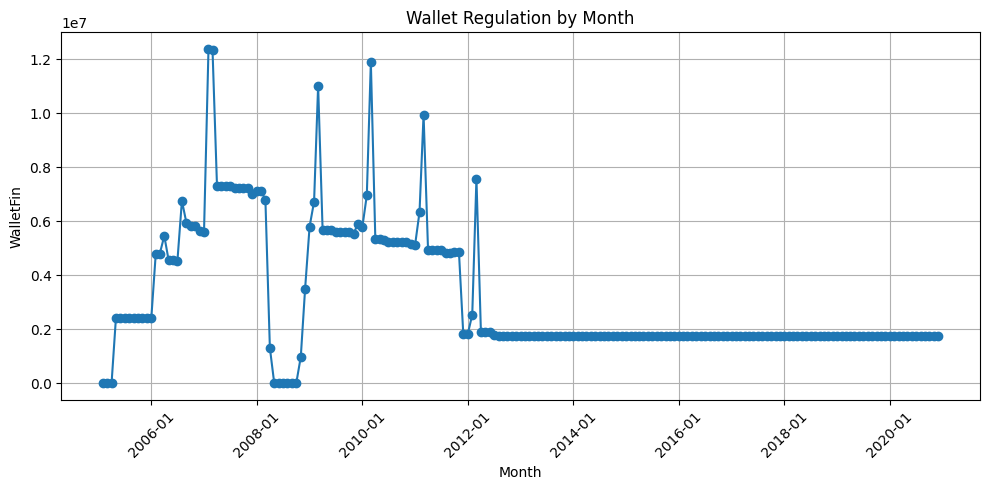

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Tracer la courbe
plt.figure(figsize=(10, 5))  # Définir la taille de la figure
plt.plot(df2_cluster1['month'], df2_cluster1['WalletFin'], marker='o', linestyle='-')  # Tracer la ligne avec des points

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# Ajouter des titres et des étiquettes
plt.title('Wallet of Financial Entities of Cluster 1')
plt.xlabel('Month')
plt.ylabel('Wallet')

# Améliorer la mise en forme de l'axe des abscisses si nécessaire
plt.xticks(rotation=45)  # Rotation des étiquettes de mois pour une meilleure lisibilité

# Afficher le graphique
plt.grid(True)  # Ajouter une grille
plt.tight_layout()  # Ajuster automatiquement les paramètres de la subpot pour donner un padding qui rend tout visible
plt.show()


CLUSTER 0

In [ ]:
import pandas as pd


regulating_df0 = df_cluster0[df_cluster0['Type'] == 'regulating']
financial_df0 = df_cluster0[df_cluster0['Type'] == 'financial']


df2_cluster0 = pd.DataFrame(df_cluster0['month'].unique(), columns=['month'])

# Setting 'month' as the index for easy merging
df2_cluster0.set_index('month', inplace=True)

# Grouping and summing 'acquired_amount' and 'transferred_amount' by 'month' for both types
invol_reg = regulating_df0.groupby('month')['acquired_amount'].sum()
outvol_reg = regulating_df0.groupby('month')['transferred_amount'].sum()
invol_fin = financial_df0.groupby('month')['acquired_amount'].sum()
outvol_fin = financial_df0.groupby('month')['transferred_amount'].sum()

# Merging these sums into df2
df2_cluster0['InVolReg'] = invol_reg
df2_cluster0['OutVolReg'] = outvol_reg
df2_cluster0['InVolFin'] = invol_fin
df2_cluster0['OutVolFin'] = outvol_fin
df2_cluster0['InVolReg'].fillna(0, inplace=True)
df2_cluster0['OutVolReg'].fillna(0, inplace=True)
df2_cluster0['InVolFin'].fillna(0, inplace=True)
df2_cluster0['OutVolFin'].fillna(0, inplace=True)

# # Calculating total volumes
df2_cluster0['TVolFin'] = df2_cluster0['InVolFin'] + df2_cluster0['OutVolFin']
df2_cluster0['TVolReg'] = df2_cluster0['InVolReg'] + df2_cluster0['OutVolReg']

# Resetting index if necessary
df2_cluster0.reset_index(inplace=True)


C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\888777680.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2_cluster0['InVolReg'].fillna(0, inplace=True)
C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\888777680.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [ ]:
print(df2_cluster0.isna().sum())

month        0
InVolReg     0
OutVolReg    0
InVolFin     0
OutVolFin    0
TVolFin      0
TVolReg      0
dtype: int64


In [ ]:
df2_cluster0.sort_values(by=['month'], inplace=True)
df2_cluster0.head()

,month,InVolReg,OutVolReg,InVolFin,OutVolFin,TVolFin,TVolReg
0,2005-02-01,50530990.0,5000.0,40465.0,0.0,40465.0,50535990.0
115,2005-03-01,6637242.0,6751460.0,5537.0,0.0,5537.0,13388702.0
114,2005-04-01,23901206.0,217491.0,107522.0,0.0,107522.0,24118697.0
127,2005-05-01,73669628.0,1781368.0,52363.0,0.0,52363.0,75450996.0
21,2005-06-01,29172398.0,3766717.0,64069.0,0.0,64069.0,32939115.0


In [ ]:
regulating_df0['NetAmountReg'] = regulating_df0['acquired_amount'] - regulating_df0['transferred_amount']

monthly_net0 = regulating_df0.groupby('month')['NetAmountReg'].sum()

df2_cluster0 = pd.merge(df2_cluster0,monthly_net0,how='left',on='month')
df2_cluster0['NetAmountReg'].fillna(0,inplace=True)
df2_cluster0['WalletReg'] = df2_cluster0['NetAmountReg'].cumsum()


df2_cluster0.head()

C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\142022089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regulating_df0['NetAmountReg'] = regulating_df0['acquired_amount'] - regulating_df0['transferred_amount']
C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\142022089.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the oper

,month,InVolReg,OutVolReg,InVolFin,OutVolFin,TVolFin,TVolReg,NetAmountReg,WalletReg
0,2005-02-01,50530990.0,5000.0,40465.0,0.0,40465.0,50535990.0,50525990.0,50525990.0
1,2005-03-01,6637242.0,6751460.0,5537.0,0.0,5537.0,13388702.0,-114218.0,50411772.0
2,2005-04-01,23901206.0,217491.0,107522.0,0.0,107522.0,24118697.0,23683715.0,74095487.0
3,2005-05-01,73669628.0,1781368.0,52363.0,0.0,52363.0,75450996.0,71888260.0,145983747.0
4,2005-06-01,29172398.0,3766717.0,64069.0,0.0,64069.0,32939115.0,25405681.0,171389428.0


In [ ]:
financial_df0['NetAmountFin'] = financial_df0['acquired_amount'] - financial_df0['transferred_amount']

monthly_net0 = financial_df0.groupby('month')['NetAmountFin'].sum()

df2_cluster0 = pd.merge(df2_cluster0,monthly_net0,how='left',on='month')
df2_cluster0['NetAmountFin'].fillna(0,inplace=True)
df2_cluster0['WalletFin'] = df2_cluster0['NetAmountFin'].cumsum()


C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\3903962793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_df0['NetAmountFin'] = financial_df0['acquired_amount'] - financial_df0['transferred_amount']
C:\Users\zoero\AppData\Local\Temp\ipykernel_20544\3903962793.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the opera

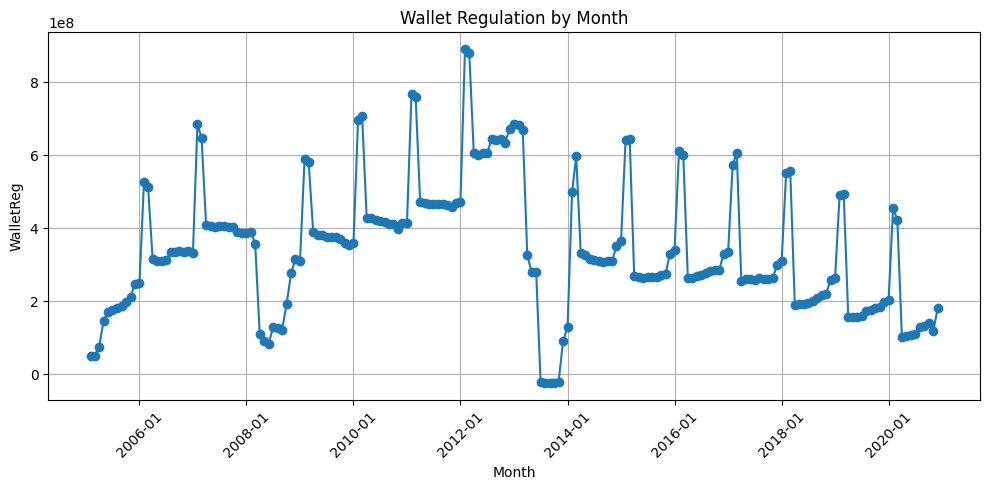

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Tracer la courbe
plt.figure(figsize=(10, 5))  # Définir la taille de la figure
plt.plot(df2_cluster0['month'], df2_cluster0['WalletReg'], marker='o', linestyle='-')  # Tracer la ligne avec des points

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# Ajouter des titres et des étiquettes
plt.title('Wallet of Regulated Entities of cluster 0')
plt.xlabel('Month')
plt.ylabel('Wallet')

# Améliorer la mise en forme de l'axe des abscisses si nécessaire
plt.xticks(rotation=45)  # Rotation des étiquettes de mois pour une meilleure lisibilité

# Afficher le graphique
plt.grid(True)  # Ajouter une grille
plt.tight_layout()  # Ajuster automatiquement les paramètres de la subpot pour donner un padding qui rend tout visible
plt.show()


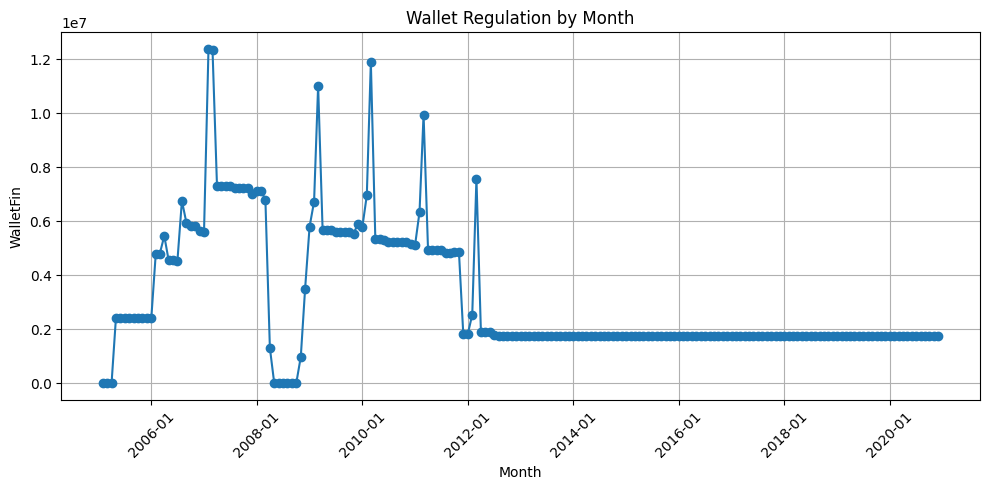

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Tracer la courbe
plt.figure(figsize=(10, 5))  # Définir la taille de la figure
plt.plot(df2_cluster1['month'], df2_cluster1['WalletFin'], marker='o', linestyle='-')  # Tracer la ligne avec des points

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# Ajouter des titres et des étiquettes
plt.title('Wallet of Financial Entities of Cluster 0')
plt.xlabel('Month')
plt.ylabel('Wallet')

# Améliorer la mise en forme de l'axe des abscisses si nécessaire
plt.xticks(rotation=45)  # Rotation des étiquettes de mois pour une meilleure lisibilité

# Afficher le graphique
plt.grid(True)  # Ajouter une grille
plt.tight_layout()  # Ajuster automatiquement les paramètres de la subpot pour donner un padding qui rend tout visible
plt.show()


In [ ]:
df2_cluster1.drop(columns=["NetAmountReg","NetAmountFin"],inplace=True)
df2_cluster0.drop(columns=["NetAmountReg","NetAmountFin"],inplace=True)
df2.drop(columns=["NetAmountReg","NetAmountFin"],inplace=True)

df2_cluster1.to_csv('wallet_data_cluster1.csv')
df2_cluster0.to_csv('wallet_data_cluster0.csv')
df2.to_csv('wallet_data.csv')

In [ ]:
types  = df_cleaned['account_type'].unique()
for t in types:
   nb_account= len(df_cleaned[df_cleaned['account_type']==t]['account_id'].unique())
   print(t,':',nb_account)
   

Voluntary Cancellation Account (Type 3) : 68
Party Holding Account : 267
Retirement Account : 53
Former Operator Holding Account : 12782
Person Account in National Registry : 3097
AAU Deposit Account : 27
Net Source Cancellation Account (Type 1) : 29
Mandatory (Cancellation Account (Type 5) : 2
Person Holding Account : 720
Trading Account : 1564
National Allowance Holding Account : 135
Gateway Deposit Account : 1
Aircraft Operator Account : 1318
Operator Holding Account : 13610
Central Clearing Account : 1
Union Allowance Deletion Account : 1
Auction Delivery Account : 4
Auction Account : 1
Aviation Auction Account : 1
Aviation Surrender Set-Aside Account : 1
Allocation Account : 1
Aviation Allocation Account : 1
tCER Replacement Account for Expiry (Type 1) : 1
EU Effort Sharing Account : 226
